In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from collections import defaultdict
from scipy.stats import chi2_contingency

In [29]:
def setFluoroStatus(x):
    if x == 'T':
        return 'Susceptible'
    elif x == 'I':
        return 'Resistant'
    else:
        return np.nan
    
gryA = defaultdict(str)
with open('14000_gryA_protein.aln.fasta') as fh:
    for line in fh:
        line = line.strip()
        if line.startswith('>'):
            name = line[1:-2]
        else:
            gryA[int(name)] += line
gryA = pd.Series(gryA).to_frame().rename({0: 'sequence'}, axis=1)
gryA.index.name = 'id'

gryA['Thr86Ile'] = gryA['sequence'].apply(lambda x: x[85])
gryA['Fluoroquinolone'] = gryA['Thr86Ile'].apply(setFluoroStatus)

In [30]:
tet_resistant = pd.read_csv('Tet0Gene_isolates_presence.txt', sep='\t')['id']

In [36]:
data = pd.read_csv('BIGSdb_1398733_6457475283_16760.ngroups.csv').set_index('id')
data['Fluoroquinolone'] = gryA['Fluoroquinolone']
data['Tetracycline'] = data.index.isin(tet_resistant)
data['Tetracycline'] = data['Tetracycline'].apply(lambda x: 'Resistant' if x else 'Susceptible')

no_status = data[['Tetracycline', 'Fluoroquinolone']].notna().all(axis=1)
data = data.loc[no_status].copy()

def setBothStatus(x):
    if x['Fluoroquinolone'] == 'Resistant':
        status = 'Fr:'
    elif x['Fluoroquinolone'] == 'Susceptible':
        status = 'Fs:'
    else:
        status = 'F0:'
    if x['Tetracycline'] == 'Resistant':
        status += 'Tr'
    elif x['Tetracycline'] == 'Susceptible':
        status += 'Ts'
    else:
        status += 'T0'
    return status

data['Status'] = data.apply(setBothStatus, axis=1)

In [37]:
drop = ([
    'aspA', 'glnA', 'gltA', 'glyA', 'pgm', 'tkt', 'uncA',
    'isolate', 'aliases', 'ST (MLST)', 'clonal_complex (MLST)',
    'penner', 'datestamp', 'isolation_date', 'received_date',
    'age_yr', 'age_mth', 'species', 'country', 'continent',
    'bioproject_accession', 'biosample_accession', 'ENA_run_accession',
    'private_project', 'comments', 'sender', 'curator', 'date_entered',
])
metadata = pd.read_csv('BIGSdb_1443529_1958928786_17262.txt', sep='\t').set_index('id').drop(drop, axis=1)

In [38]:
data = pd.merge(data, metadata, left_index=True, right_index=True)
data['source'] = data['source'].fillna('Unknown')

In [65]:
data.groupby('source').apply(lambda x: (x['Fluoroquinolone'] == 'Resistant').sum() / len(x) ).sort_values()

source
CSF                      0.000000
rabbit                   0.000000
turkey offal or meat     0.000000
environmental waters     0.000000
cattle                   0.029499
wild bird                0.031250
other animal             0.035088
sheep                    0.053571
lamb offal or meat       0.059829
duck                     0.100000
beef offal or meat       0.103896
broiler environment      0.111111
farm environment         0.250000
chicken                  0.300387
human stool              0.321292
human unspecified        0.333333
Unknown                  0.387733
human blood culture      0.400000
chicken offal or meat    0.402985
turkey                   0.412371
dtype: float64

<AxesSubplot: xlabel='year', ylabel='0'>

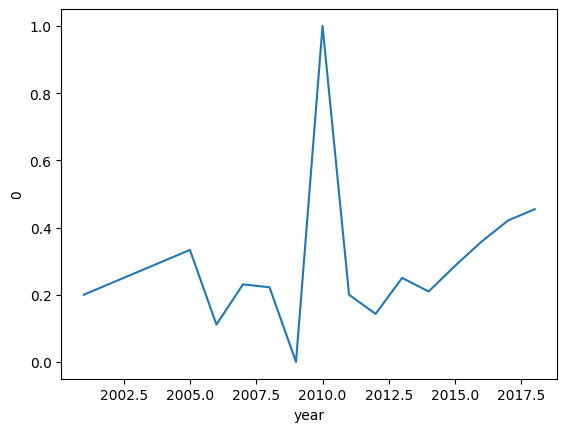

In [75]:
a = data.loc[data['source'] == 'chicken', ['Fluoroquinolone', 'year']]
a['Fluoroquinolone'] = a['Fluoroquinolone'] == 'Resistant'
a = a.groupby('year').apply(lambda x: x['Fluoroquinolone'].sum() / len(x)).reset_index().sort_values('year')

fig, ax = plt.subplots()
sns.lineplot(data=a, x='year', y=0)

In [78]:
classification = 'year'
all_tests = []
z_scores = []
prop = []
n_reps = 10_000
# Get total isolates per NGroup
group_size = data.groupby(classification).size().rename('n')
# NGroups with good sample size
valid_ng = group_size[group_size > 100].index
for group in ['Both', 'Fluoroquinolone', 'Tetracycline', 'Neither']:
    
    if group == 'Both':
        data['ref'] = (data['Fluoroquinolone'] == 'Resistant') & (data['Tetracycline'] == 'Resistant')
    elif group == 'Fluoroquinolone':
        data['ref'] = (data['Fluoroquinolone'] == 'Resistant') & (data['Tetracycline'] == 'Susceptible')
    elif group == 'Tetracycline':
        data['ref'] = (data['Tetracycline'] == 'Resistant') & (data['Fluoroquinolone'] == 'Susceptible')
    elif group == 'Neither':
        data['ref'] = (data['Fluoroquinolone'] == 'Susceptible') & (data['Tetracycline'] == 'Susceptible')
    else:
        continue

    shuffles = []
    for i in range(n_reps):
        data['random'] = data['ref'].sample(frac=1).values
        shuffles.append(data.groupby(classification)['random'].sum().rename(i))
    shuffles = pd.concat(shuffles, axis=1)

    scores = pd.concat([
        group_size,
        data.groupby(classification)['ref'].sum().rename('obs'),
        shuffles.mean(axis=1).rename('mean'),
        shuffles.std(axis=1).rename('std')
    ], axis=1)
    scores['z'] = (scores['obs'] - scores['mean']) / scores['std']
    scores['prop'] = scores['obs'] / scores['n']
    scores['group'] = group
    
    all_tests.append(scores)
    z_scores.append(scores['z'].rename(group))
    prop.append(scores['prop'].rename(group))
    
all_tests = pd.concat(all_tests)
z_scores = pd.concat(z_scores, axis=1)
prop = pd.concat(prop, axis=1)

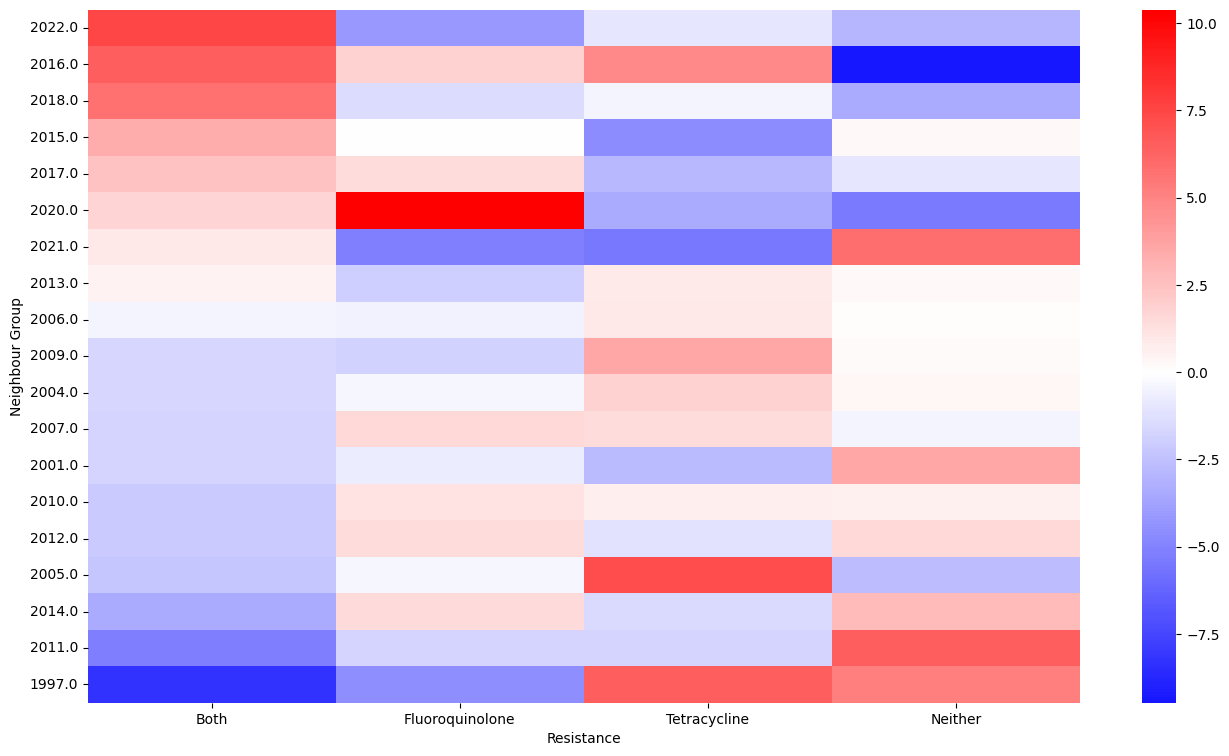

In [79]:
valid = z_scores.index.isin(valid_ng)
sub = z_scores.loc[valid].sort_values('Both', ascending=False)

fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(data=sub, cmap='bwr', center=0, ax=ax)
ax.set_xlabel('Resistance')
ax.set_ylabel('Neighbour Group')
fig.savefig('ResistanceStatus-z.svg')

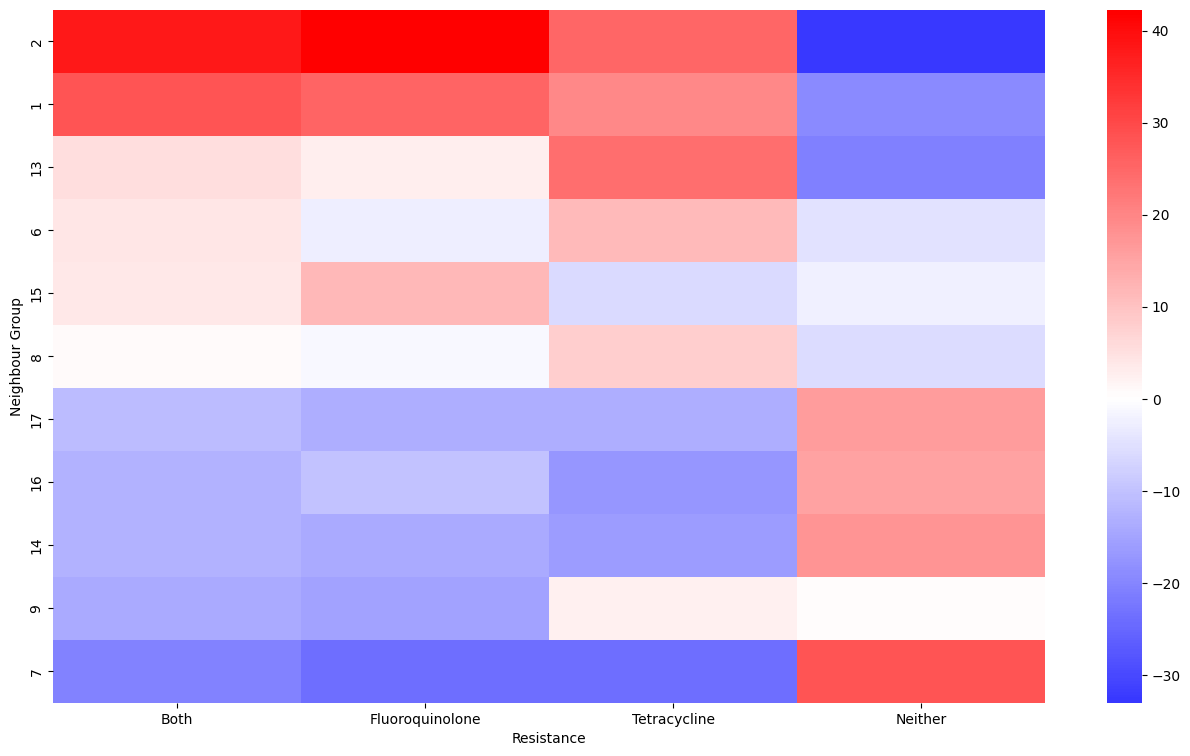

In [41]:
valid = z_scores.index.isin(valid_ng)
sub = z_scores.loc[valid].sort_values('Both', ascending=False)

fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(data=sub, cmap='bwr', center=0, ax=ax)
ax.set_xlabel('Resistance')
ax.set_ylabel('Neighbour Group')
fig.savefig('ResistanceStatus-z.svg')

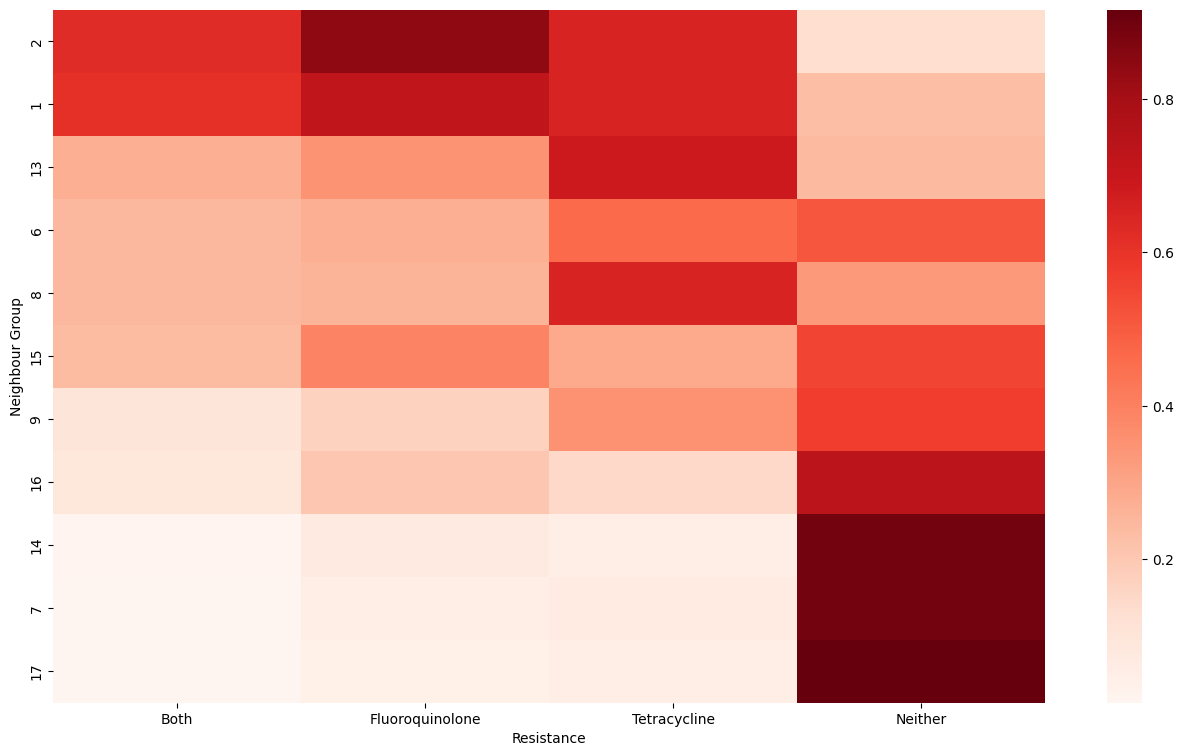

In [9]:
valid = prop.index.isin(valid_ng)
sub = prop.loc[valid].sort_values('Both', ascending=False)

fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(data=sub, cmap='Reds', ax=ax)
ax.set_xlabel('Resistance')
ax.set_ylabel('Neighbour Group')
fig.savefig('ResistanceStatus-prop.svg')

In [10]:
def makeCountTable(data, NG):
    counts = (
        data.loc[data['NG'] == NG].groupby('year')['Status']
        .value_counts()
        .rename('count')
        .reset_index()
        .pivot(index='Status', columns='year')
        .fillna(0)
        .droplevel(0, axis=1)
        .reset_index()
        .melt(id_vars='Status')
    )
    return counts

In [ ]:
NG = 8

fig, ax = plt.subplots()
sns.lineplot(data=makeCountTable(data, NG), x='year', y='value', hue='Status')
ax.set_title(f'NG{NG}', loc='left')
ax.set_xlabel('Year')
ax.set_ylabel('Isolates')

Text(0, 0.5, 'Isolates')